In [3]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img
import tensorflow as tf
from datasets import load_dataset
import numpy as np
import seaborn as sns
import pandas as pd


In [4]:
dataset = load_dataset("Kaludi/data-food-classification")
class_dict = {
    0: 'apple_pie',
    1: 'falafel',
    2: 'french_toast',
    3: 'ice_cream',
    4: 'ramen',
    5: 'sushi',
    6: 'tiramisu'
}



Resolving data files:   0%|          | 0/1052 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/352 [00:00<?, ?it/s]

In [5]:
def preprocess_image(example):
    from tensorflow.keras.preprocessing.image import img_to_array
    from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input 
    image = example['image'].resize((299,299))
    image = img_to_array(image)
    image = preprocess_input(image)
    return {"image": image, "label": example['label']}

dataset = dataset.map(preprocess_image, num_proc=1)
batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices((np.stack(dataset['train']['image']), np.array(dataset['train']['label']))).batch(batch_size).shuffle(1000).prefetch(tf.data.AUTOTUNE)
validation_dataset = tf.data.Dataset.from_tensor_slices((np.stack(dataset['validation']['image']), np.array(dataset['validation']['label']))).batch(batch_size).prefetch(tf.data.AUTOTUNE)



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)  

model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
optimizer = Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, callbacks=[early_stopping])



Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.2878 - loss: 1.9291 - val_accuracy: 0.5829 - val_loss: 1.3646
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.5158 - loss: 1.3679 - val_accuracy: 0.6800 - val_loss: 1.0856
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.6799 - loss: 1.0236 - val_accuracy: 0.6886 - val_loss: 0.9732
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.6712 - loss: 0.9553 - val_accuracy: 0.7657 - val_loss: 0.8141
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.7034 - loss: 0.8529 - val_accuracy: 0.7914 - val_loss: 0.6974
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.7777 - loss: 0.6667 - val_accuracy: 0.8200 - val_loss: 0.6349
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.7719 - loss: 0.7081 - val_accuracy: 0.8143 - val_loss: 0.6250
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.8084 - loss: 0.5915 - val_accuracy: 0.

[Text(0.5, 1.0, 'Training and Validation Loss Curve'),
 Text(0.5, 0, 'Epoch'),
 Text(0, 0.5, 'Loss')]

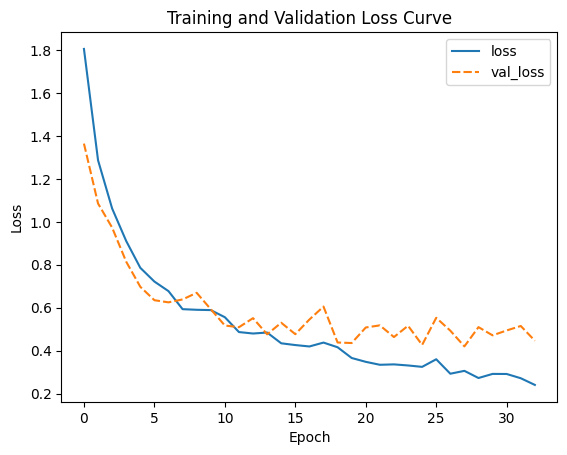

In [19]:
history_df = pd.DataFrame(history.history)
sns.lineplot(data=history_df[['loss','val_loss']]).set(title="Training and Validation Loss Curve", xlabel="Epoch", ylabel="Loss")

In [20]:
training_loss, training_accuracy = model.evaluate(train_dataset)
validation_loss, validation_accuracy = model.evaluate(validation_dataset)


print(f"Training Loss: {training_loss}, Training Accuracy: {training_accuracy}")
print(f"Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}")

66/66 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.9370 - loss: 0.2301
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8638 - loss: 0.4509
Training Loss: 0.2388383448123932, Training Accuracy: 0.939047634601593
Validation Loss: 0.41970258951187134, Validation Accuracy: 0.868571400642395
